## Power Trace CDFs and Representative Plots

In [1]:
import argparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import seaborn as sns

from model.core.dataset import PowerTraceDataset
from model.core.utils import load_classifier
from model.predictors.smooth_sampler import SmoothingSampler

In [2]:
def compute_autocorrelation_metrics(real_trace, synthetic_trace, max_lags=50):
    """
    Compare temporal autocorrelation between real and synthetic traces
    """
    real_acf = acf(real_trace, nlags=max_lags, fft=True)
    synthetic_acf = acf(synthetic_trace, nlags=max_lags, fft=True)
    acf_correlation, _ = pearsonr(real_acf, synthetic_acf)
    acf_mae = np.mean(np.abs(real_acf - synthetic_acf))

    return {
        "real_acf": real_acf,
        "synthetic_acf": synthetic_acf,
        "acf_correlation": acf_correlation,
        "acf_mae": acf_mae,
    }


In [ ]:
# data_file = "./data/benchmark_gpt-oss-120b_a100.npz"
# model = "gpt-oss-120b"
# hardware_accelerator = "a100"
# weights_path = "./results/training/gpt-oss-120b_h100_tp4"
# device="cpu"
# hw="a100"

data_file = "/Users/grantwilkins/powertrace-sim/model/training_data/vllm-benchmark_llama-3-8b_a100.npz"
model = "llama-3-8b"
hardware_accelerator = "a100"
weights_path = "./model/sharegpt_gru_classifier_weights/"
device="cpu"
hw="a100"

In [4]:

dataset = PowerTraceDataset(data_file)
print(dataset.mu[8])
tp_values = [4]
tp_color_key = {
    1: "#1f77b4",  # blue
    2: "#ff7f0e",  # orange
    4: "#2ca02c",  # green
    8: "#d62728",  # red
}

cdf_data = []
np.random.seed(42)
Dx = dataset.traces[0]["x"].shape[1]
print(f"Dataset features: Dx={Dx}")

for tp in tp_values:
    print(f"\nProcessing TP={tp}")
    print(f"Using Dx={Dx} features")
    classifier = load_classifier(
        f"{weights_path}/model_tp{tp}_H64_biGRU.pt",
        # f"{weights_path}/{model}_{hardware_accelerator}_tp{tp}.pt",
        device=device,
        Dx=10,
        K=6,
    )
    smoother = SmoothingSampler(dataset)
    tp_indices = [i for i, tp_i in enumerate(dataset.tp_all) if tp_i == tp]

    all_original_power = []
    all_sampled_power = []
    sampled_power_arrs = {}
    import scipy.stats as stats

    min_power = float("inf")
    max_power = float("-inf")
    for idx in tp_indices:
        trace_power = dataset.traces[idx]["y"].flatten()
        min_power = min(min_power, np.min(trace_power))
        max_power = max(max_power, np.max(trace_power))

    for idx in tp_indices:
        time, power, states = smoother.sample_power(
            classifier,
            dataset.mu[tp],
            dataset.sigma[tp],
            dataset.traces[idx]["x"],
            dt=0.25,
            smoothing_window=5,
        )
        power = np.clip(power, min_power, max_power)
        original_power = dataset.traces[idx]["y"].flatten()
        sampled_power = power.flatten()
        sampled_power_arrs[idx] = (time, sampled_power)
        all_original_power.append(original_power)
        all_sampled_power.append(sampled_power)

    all_original_power = np.concatenate(all_original_power)
    all_sampled_power = np.concatenate(all_sampled_power)
    overall_ks_stat, overall_p_value = stats.ks_2samp(
        all_original_power, all_sampled_power
    )
    print(f"Overall - KS Statistic: {overall_ks_stat}, p-value: {overall_p_value}")
    sorted_original_power = np.sort(all_original_power)
    sorted_sampled_power = np.sort(all_sampled_power)

    cdf_original = np.arange(1, len(sorted_original_power) + 1) / len(
        sorted_original_power
    )
    cdf_sampled = np.arange(1, len(sorted_sampled_power) + 1) / len(
        sorted_sampled_power
    )

    # Add data to cdf_data list
    cdf_data.extend(
        [
            {"Power": p, "CDF": c, "Type": "Original", "TP": tp}
            for p, c in zip(sorted_original_power, cdf_original)
        ]
    )
    cdf_data.extend(
        [
            {"Power": p, "CDF": c, "Type": "Sampled", "TP": tp}
            for p, c in zip(sorted_sampled_power, cdf_sampled)
        ]
    )

    print(f"TP={tp} indices:", dataset.tp_all)

    total_energy_original = np.trapz(all_original_power, dx=0.25)
    total_energy_sampled = np.trapz(all_sampled_power, dx=0.25)
    print(f"Total energy consumed (original): {total_energy_original:.2f} J")
    print(f"Total energy consumed (sampled): {total_energy_sampled:.2f} J")
    print(
        f"Energy difference: {total_energy_sampled - total_energy_original:.2f} J"
    )

    # Compute autocorrelation metrics
    print("Computing autocorrelation metrics...")
    autocorr_metrics = compute_autocorrelation_metrics(
        all_original_power, all_sampled_power
    )
    print("Autocorrelation metrics:")
    print(f"ACF Correlation: {autocorr_metrics['acf_correlation']:.4f}")
    print(f"ACF MAE: {autocorr_metrics['acf_mae']:.4f}")

    # Compute earth mover's distance
    from scipy.stats import wasserstein_distance

    emd = wasserstein_distance(sorted_original_power, sorted_sampled_power)
    print(f"Earth Mover's Distance: {emd:.4f}")

    # Calculate p99 error
    p99_original = np.percentile(all_original_power, 99)
    p99_sampled = np.percentile(all_sampled_power, 99)
    p99_error = np.abs(p99_original - p99_sampled) / p99_original * 100
    print(f"P99 Error: {p99_error:.2f}%")

    # Calculate p95 error
    p95_original = np.percentile(all_original_power, 95)
    p95_sampled = np.percentile(all_sampled_power, 95)
    p95_error = np.abs(p95_original - p95_sampled) / p95_original * 100
    print(f"P95 Error: {p95_error:.2f}%")

    # Compute NRMSE
    nrmse = np.sqrt(np.mean((all_original_power - all_sampled_power) ** 2)) / (
        np.max(all_original_power) - np.min(all_original_power)
    )
    print(f"NRMSE: {nrmse:.4f}")


[1148.8237905   559.60415019 1680.00804015 2046.1975227  1367.95284077
  680.53956732]
Dataset features: Dx=10

Processing TP=4
Using Dx=10 features
Loading classifier from ./results/training/gpt-oss-120b_h100_tp4/model_tp4_H64_biGRU.pt on device: cpu


/Users/grantwilkins/powertrace-sim/model/core/utils.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(path, map_location=device))


Overall - KS Statistic: 0.2486746987951807, p-value: 0.0
TP=4 indices: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Total energy consumed (original): 7731412.00 J
Total energy consumed (sampled): 9528553.81 J
Energy difference: 1797141.81 J
Computing autocorrelation metrics...
Autocorrelation metrics:
ACF Correlation: 0.9432
ACF MAE: 0.2884
Earth Mover's Distance: 185.5531
P99 Error: 3.52%
P95 Error: 0.20%
NRMSE: 0.5709


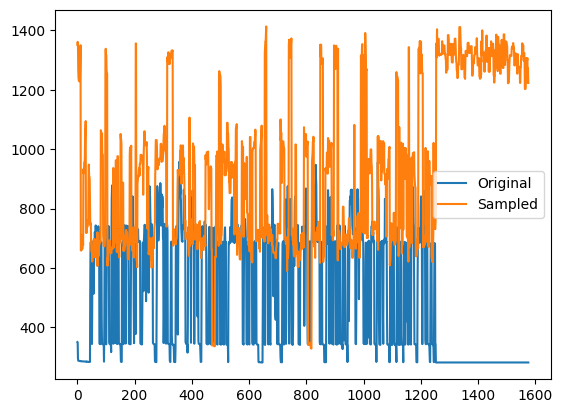

In [5]:
plt.plot(original_power, label="Original")
plt.plot(sampled_power, label="Sampled")
plt.legend()
plt.show()


In [6]:
dataset = PowerTraceDataset("./model/training_data/vllm-benchmark_llama-3-8b_a100.npz")
all_original_power = []
tp_indices = [i for i, tp_i in enumerate(dataset.tp_all) if tp_i == 1]
for idx in tp_indices:
    original_power = dataset.traces[idx]["y"].flatten()
    all_original_power.append(original_power)

all_original_power = np.concatenate(all_original_power)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.9)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(8, 6))
sns.ecdfplot(all_original_power / all_original_power.max(), label="Original", linewidth=4)
plt.ylim(0, 1.05)
plt.xlabel("Normalized Power")
plt.ylabel("CDF")
plt.savefig("power_traces_cdf.pdf", bbox_inches="tight")

KeyboardInterrupt: 

## Training Curves

In [ ]:
import glob
big_df = pd.DataFrame()
for f in glob.glob("./results/training/*/*epochs.csv", recursive=True):
    model = f.split("/")[3].split("_")[0]
    hw = f.split("/")[3].split("_")[1]
    tp = f.split("/")[3].split("_")[2].split("tp")[-1]
    df = pd.read_csv(f)
    df = df[df["epoch"] <= 500]
    model_legend = "Llama-3.1 (70B)" if model == "llama-3-70b" else "Llama-3.1 (8B)" if model == "llama-3-8b" else "gpt-oss (20B)" if model =="gpt-oss-20b" else "gpt-oss (120B)"
    df["Model"] = model_legend
    df["TP"] = tp
    df["GPU"] = hw.upper()
    big_df = pd.concat([big_df, df], ignore_index=True)


In [ ]:
best_configs = big_df.groupby(["Model", "GPU", "TP"]).agg({
    "val_f1": "max",
    "val_autocorr_r2": "max",
    "val_transition_mae": "min",  # Lower is better for MAE
}).reset_index()

metrics = {
    "Validation F1": ("val_f1", "↑"),
    "Autocorr R²": ("val_autocorr_r2", "↑"),
    "Transition MAE (W)": ("val_transition_mae", "↓"),
}

for model in best_configs["Model"].unique():
    print(f"\n\\textbf{{{model}}}")
    print("\\textbf{Metric} & \\textbf{Mean} & \\textbf{Std.} \\\\")
    print("\\midrule")
    model_data = best_configs[best_configs["Model"] == model]
    for metric_name, (col_name, direction) in metrics.items():
        if col_name == "val_transition_mae":
            # Split by TP for transition MAE
            for tp in sorted(model_data["TP"].unique()):
                tp_data = model_data[model_data["TP"] == tp]
                mean_val = tp_data[col_name].mean()
                std_val = tp_data[col_name].std()
                print(f"{metric_name} (TP={tp}) ${direction}$ & {mean_val:.2f} & {std_val:.2f} \\\\")
        else:
            mean_val = model_data[col_name].mean()
            std_val = model_data[col_name].std()
            print(f"{metric_name} ${direction}$ & {mean_val:.2f} & {std_val:.2f} \\\\")



\textbf{Llama-3.1 (70B)}
\textbf{Metric} & \textbf{Mean} & \textbf{Std.} \\
\midrule
Validation F1 $↑$ & 0.49 & 0.08 \\
Autocorr R² $↑$ & 0.98 & 0.01 \\
Transition MAE (W) (TP=4) $↓$ & 198.76 & 147.08 \\
Transition MAE (W) (TP=8) $↓$ & 337.95 & 23.43 \\

\textbf{Llama-3.1 (8B)}
\textbf{Metric} & \textbf{Mean} & \textbf{Std.} \\
\midrule
Validation F1 $↑$ & 0.43 & 0.06 \\
Autocorr R² $↑$ & 0.99 & 0.01 \\
Transition MAE (W) (TP=1) $↓$ & 45.64 & 16.46 \\
Transition MAE (W) (TP=2) $↓$ & 51.25 & 40.60 \\

\textbf{gpt-oss (120B)}
\textbf{Metric} & \textbf{Mean} & \textbf{Std.} \\
\midrule
Validation F1 $↑$ & 0.34 & 0.02 \\
Autocorr R² $↑$ & 0.85 & 0.09 \\
Transition MAE (W) (TP=4) $↓$ & 237.36 & 87.79 \\
Transition MAE (W) (TP=8) $↓$ & 359.94 & 56.81 \\

\textbf{gpt-oss (20B)}
\textbf{Metric} & \textbf{Mean} & \textbf{Std.} \\
\midrule
Validation F1 $↑$ & 0.40 & 0.06 \\
Autocorr R² $↑$ & 0.88 & 0.09 \\
Transition MAE (W) (TP=1) $↓$ & 62.12 & 34.95 \\
Transition MAE (W) (TP=2) $↓$ & 83.53 & 


\textbf{Expected Calibration Error (ECE)}
\textbf{Model} & \textbf{Mean} & \textbf{Std.} \\
\midrule
Llama-3.1 (70B) & 0.0886 & 0.0298 \\
gpt-oss (120B) & 0.0437 & 0.0162 \\
gpt-oss (20B) & 0.0578 & 0.0361 \\


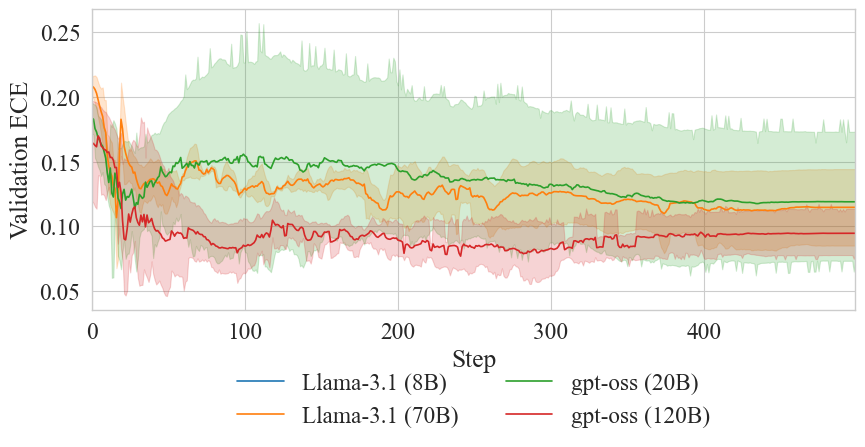

In [ ]:
import os
wandb_file = os.path.expanduser("~/Downloads/wandb_export_2025-10-28T11_13_46.707-07_00.csv")
ece_df = pd.read_csv(wandb_file)
ece_big_df = pd.DataFrame()
for col in ece_df.columns:
    if col == "Step":
        continue
    if "__MIN" in col or "__MAX" in col:
        continue
    parts = col.split(" - ")[0].split("_")
    model = parts[0]
    hw = parts[1]
    tp = parts[2].replace("tp", "")
    
    temp_df = pd.DataFrame({
        "Step": ece_df["Step"],
        "val_ece": ece_df[col]
    })
    
    model_legend = "Llama-3.1 (70B)" if model == "llama-3-70b" else "Llama-3.1 (8B)" if model == "llama-3-8b" else "gpt-oss (20B)" if model == "gpt-oss-20b" else "gpt-oss (120B)"
    temp_df["Model"] = model_legend
    temp_df["TP"] = tp
    temp_df["GPU"] = hw.upper()
    
    ece_big_df = pd.concat([ece_big_df, temp_df], ignore_index=True)

ece_best_configs = ece_big_df.groupby(["Model", "GPU", "TP"]).agg({
    "val_ece": "min", 
}).reset_index()
print("\n\\textbf{Expected Calibration Error (ECE)}")
print("\\textbf{Model} & \\textbf{Mean} & \\textbf{Std.} \\\\")
print("\\midrule")
for model in ece_best_configs["Model"].unique():
    model_data = ece_best_configs[ece_best_configs["Model"] == model]
    mean_val = model_data["val_ece"].mean()
    std_val = model_data["val_ece"].std()
    print(f"{model} & {mean_val:.4f} & {std_val:.4f} \\\\")

# Plot ECE over training
plt.figure(figsize=(9,5.1))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.9)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"
sns.lineplot(x="Step", y="val_ece", data=ece_big_df, hue="Model", hue_order=["Llama-3.1 (8B)", "Llama-3.1 (70B)", "gpt-oss (20B)", "gpt-oss (120B)"])
plt.xlabel("Step")
plt.ylabel("Validation ECE")
plt.xlim(0, ece_big_df["Step"].max())
plt.legend(frameon=False, bbox_to_anchor=(0.5, -0.3), loc='center', ncol=2)
plt.tight_layout()
plt.savefig("val_ece_models.pdf", bbox_inches="tight")


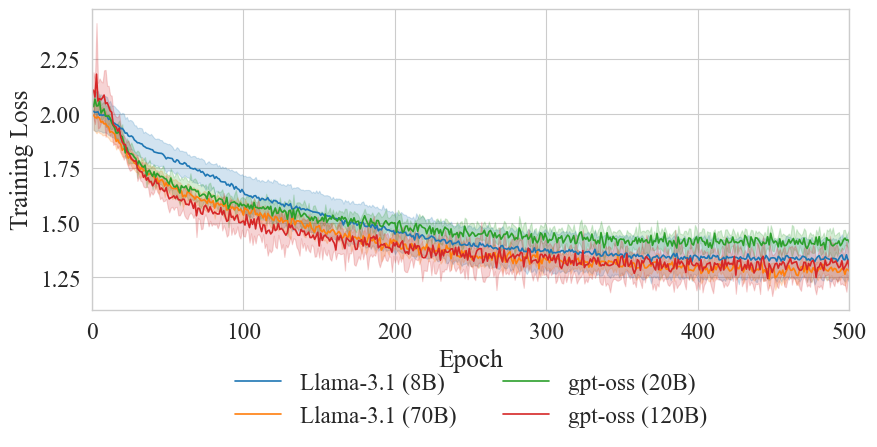

In [ ]:
plt.figure(figsize=(9,5.1))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.9)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"
sns.lineplot(x="epoch", y="train_loss", data=big_df, hue="Model", hue_order=["Llama-3.1 (8B)", "Llama-3.1 (70B)", "gpt-oss (20B)", "gpt-oss (120B)"])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.xlim(0,500)
# plt.legend("",[],frameon=False)
plt.legend(frameon=False,bbox_to_anchor=(0.5, -0.3), loc='center', ncol=2)
plt.tight_layout()
plt.savefig("training_loss_models.pdf", bbox_inches="tight")
# plt.legend(frameon=False,bbox_to_anchor=(1.05, 0.75), loc='upper left')

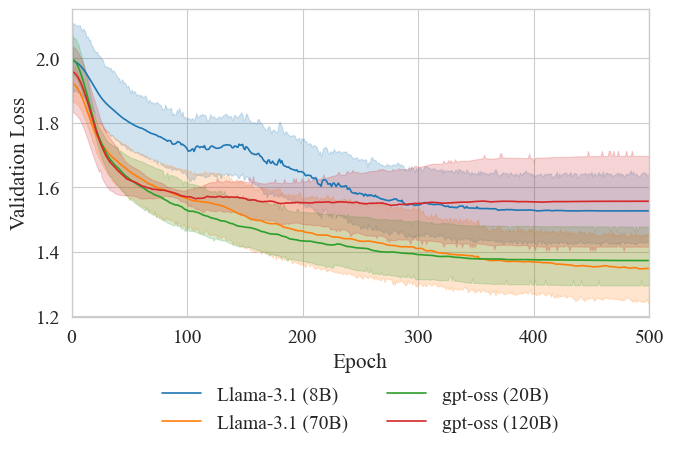

In [ ]:
plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"
sns.lineplot(x="epoch", y="val_loss", data=big_df, hue="Model", hue_order=["Llama-3.1 (8B)", "Llama-3.1 (70B)", "gpt-oss (20B)", "gpt-oss (120B)"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.xlim(0,500)
plt.legend(frameon=False,bbox_to_anchor=(0.5, -0.3), loc='center', ncol=2)
plt.tight_layout()
# plt.ylim(1.0, 2.25)
plt.savefig("val_loss_models.pdf", bbox_inches="tight")

## GMM Motivation and State Picture 

In [ ]:
# all_power_traces = []
# for f in glob.glob("./model/training_data/*llama*.npz"):
#     data = np.load(f)
#     power_traces = data['power_traces']
#     # Normalize to max
#     normalized = power_traces / power_traces.max()
#     all_power_traces.extend(normalized.flatten())
f = "./data/benchmark_llama-3-70b_a100.npz"
data = np.load(f)
power_traces = data['power_traces']
# Normalize to max
normalized = power_traces 
all_power_traces = normalized.flatten()


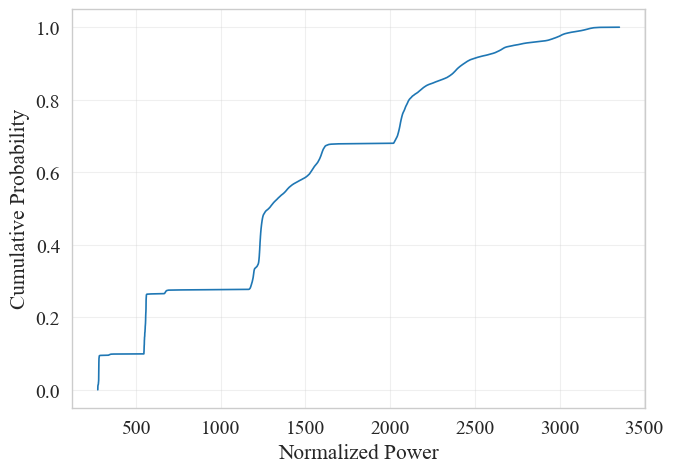

In [ ]:
# Plot CDF
plt.figure(figsize=(7,5))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

sorted_traces = np.sort(all_power_traces)
cumulative = np.arange(1, len(sorted_traces) + 1) / len(sorted_traces)
plt.plot(sorted_traces, cumulative)
plt.xlabel("Normalized Power")
plt.ylabel("Cumulative Probability")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("power_traces_cdf.pdf", bbox_inches="tight")
plt.show()